In [36]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

In [37]:
#AIM: 
# Loads brain tumor images from folders.
# Divides each image into small patches.
# Turns each image into a graph, where:
# Each patch becomes a node.
# Nearby patches are connected with edges.
# Outputs a graph object for use in graph neural networks (GNNs)


train_dir = "D:/DS_PYTHON_LUMINAR/MACHINE_LEARNING/XAI/2_Brain_tumour/Training"
test_dir = "D:/DS_PYTHON_LUMINAR/MACHINE_LEARNING/XAI/2_Brain_tumour/Testing"
patch_size = 32
transform = None

In [38]:
# SETUP LABELS
classes = os.listdir(train_dir)  # get the 4 categories
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [39]:
print('The number of class:',len(classes))
print(classes)


# Count images in each class folder (Training)
print("Training set distribution:")
for cls in classes:
    path = os.path.join(train_dir, cls)
    print(f"  {cls}: {len(os.listdir(path))} images")

# Count images in each class folder (Testing)
print("\n Testing set distribution:")
for cls in os.listdir(test_dir):
    path = os.path.join(test_dir, cls)
    print(f"  {cls}: {len(os.listdir(path))} images")

The number of class: 4
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Training set distribution:
  glioma_tumor: 822 images
  meningioma_tumor: 822 images
  no_tumor: 395 images
  pituitary_tumor: 826 images

 Testing set distribution:
  glioma_tumor: 100 images
  meningioma_tumor: 115 images
  no_tumor: 105 images
  pituitary_tumor: 74 images


In [40]:

# Empty lists to store image graphs lists
train_graphs = []
test_graphs = []

In [ ]:
# ============================================
# Loose Skull-Stripping Function
# ============================================
def skull_strip(img_rgb):
    gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological cleanup
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Keep largest connected component (brain/skull)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [largest], -1, 255, -1)

    mask = (mask > 0).astype(np.uint8)
    img_masked = img_rgb * mask[:, :, None]
    return img_masked, mask



# Process both TRAIN and TEST datasets

for dataset_type, path_dir, graph_list in [("Train", train_dir, train_graphs),
                                           ("Test", test_dir, test_graphs)]:
    print(f"Processing {dataset_type} dataset...")

    file_paths = []
    labels = []

    # Collect all images and labels
    for label in classes:
        folder = os.path.join(path_dir, label)
        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.png')):
                file_paths.append(os.path.join(folder, img_file))
                labels.append(label)

    # Create graph data for each image
    for idx in range(len(file_paths)):
        img_path = file_paths[idx]
        label = label_encoder.transform([labels[idx]])[0]

        # Load & normalize image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256)) / 255.0

        if transform:
            img = transform(img)

        # Apply skull-stripping mask
        img_masked, mask = skull_strip(img)

        H, W, _ = img_masked.shape
        patches = []
        coords = []

        # Divide into patches (only inside mask)
        for i in range(0, H, patch_size):
            for j in range(0, W, patch_size):
                cy, cx = int(i + patch_size / 2), int(j + patch_size / 2)
                if cy < H and cx < W and mask[cy, cx] > 0:
                    patch = img_masked[i:i+patch_size, j:j+patch_size, :]
                    patches.append(patch)
                    coords.append((cy + patch_size / 2, cx + patch_size / 2))

        if len(patches) == 0:
            continue  # skip empty images

        # Normalize coordinates (0–1)
        coords = np.array(coords) / np.array([H, W])

        # Compute patch-level features (mean RGB)
        features = [p.mean(axis=(0, 1)) for p in patches]
        x = torch.tensor(np.array(features), dtype=torch.float)

        # Build edges between spatially close patches
        num_nodes = len(coords)
        edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j:
                    dist = np.linalg.norm(coords[i] - coords[j])
                    if dist < 0.3:
                        edges.append([i, j])

        if len(edges) == 0:
            continue  # skip if no connectivity

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        y = torch.tensor([label], dtype=torch.long)

        # Create graph data object
        graph = Data(x=x, edge_index=edge_index, y=y)
        graph_list.append(graph)

    print(f"{dataset_type} dataset processed. Total graphs: {len(graph_list)}")


Processing Train dataset...
Train dataset processed. Total graphs: 2865
Processing Test dataset...
Test dataset processed. Total graphs: 394


🖼️ Visualizing: D:/DS_PYTHON_LUMINAR/MACHINE_LEARNING/XAI/2_Brain_tumour/Training\glioma_tumor\gg (1).jpg
✅ Graph created with 28 nodes and 348 edges


C:\Users\neham\AppData\Local\Temp\ipykernel_9244\3228404305.py:160: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\neham\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


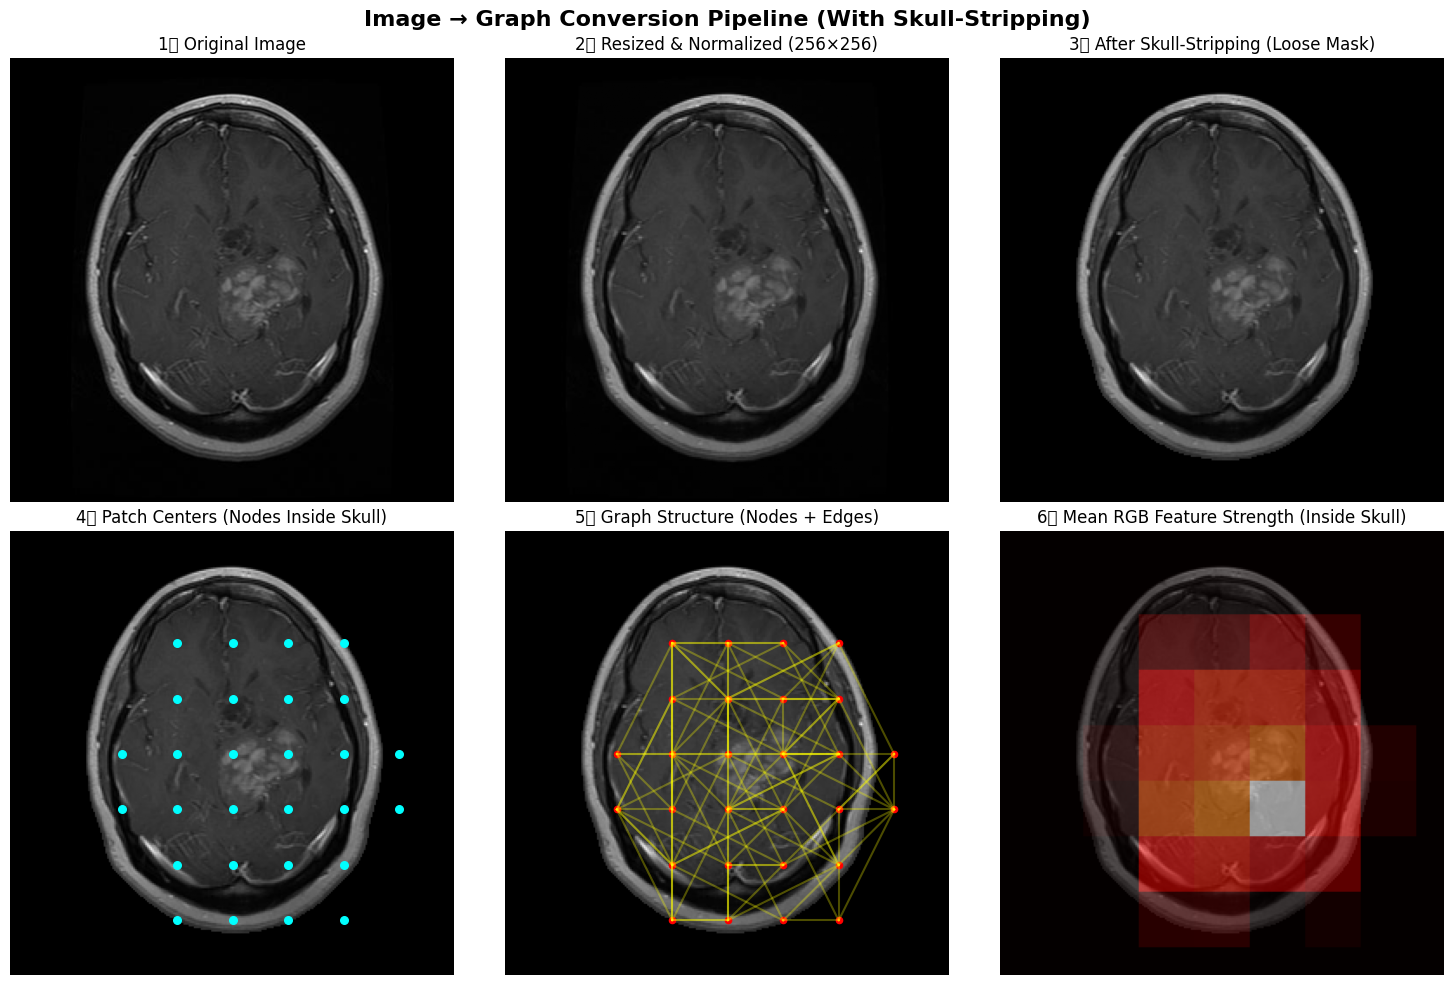

In [ ]:
# ====================================
# VISUALIZE IMAGE → GRAPH PIPELINE (with Skull-Stripping)
# ====================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data

# ====================================
# CONFIGURATION
# ====================================
sample_index = 0   # pick any index from your dataset
dataset_type = "Train"  # or "Test"
patch_size = 32

# Choose dataset path
if dataset_type == "Train":
    path_dir = train_dir
else:
    path_dir = test_dir

# Build list of all image paths
file_paths_list = [
    os.path.join(path_dir, c, f)
    for c in classes
    for f in os.listdir(os.path.join(path_dir, c))
    if f.lower().endswith(('.jpg', '.png'))
]

img_path = file_paths_list[sample_index]
print(f"🖼️ Visualizing: {img_path}")

# ====================================
# STEP 1 — LOAD AND NORMALIZE IMAGE
# ====================================
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (256, 256))
img_norm = img_resized / 255.0

# ====================================
# STEP 2 — SKULL STRIPPING (Loose Mask)
# ====================================
def skull_strip(img_rgb):
    gray = cv2.cvtColor((img_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [largest], -1, 255, -1)

    mask = (mask > 0).astype(np.uint8)
    img_masked = img_rgb * mask[:, :, None]
    return img_masked, mask

img_masked, mask = skull_strip(img_norm)

# ====================================
# STEP 3 — DIVIDE INTO PATCHES (inside brain/skull only)
# ====================================
H, W, _ = img_masked.shape
patches, coords = [], []

for i in range(0, H, patch_size):
    for j in range(0, W, patch_size):
        cy, cx = int(i + patch_size / 2), int(j + patch_size / 2)
        if cy < H and cx < W and mask[cy, cx] > 0:
            patch = img_masked[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            coords.append((cy + patch_size / 2, cx + patch_size / 2))

coords = np.array(coords) / np.array([H, W])

# ====================================
# STEP 4 — COMPUTE FEATURES (mean RGB)
# ====================================
features = [p.mean(axis=(0, 1)) for p in patches]
x = torch.tensor(np.array(features), dtype=torch.float)

# ====================================
# STEP 5 — BUILD EDGES (proximity-based)
# ====================================
num_nodes = len(coords)
edges = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist < 0.3:
                edges.append([i, j])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
graph = Data(x=x, edge_index=edge_index)

print(f"✅ Graph created with {graph.num_nodes} nodes and {graph.num_edges} edges")

# ====================================
# STEP 6 — VISUALIZATION
# ====================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Image → Graph Conversion Pipeline (With Skull-Stripping)", fontsize=16, fontweight='bold')

# (1) Original Image
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title("1️⃣ Original Image")
axes[0, 0].axis("off")

# (2) Resized + Normalized
axes[0, 1].imshow(img_norm)
axes[0, 1].set_title("2️⃣ Resized & Normalized (256×256)")
axes[0, 1].axis("off")

# (3) Skull-Stripped Image
axes[0, 2].imshow(img_masked)
axes[0, 2].set_title("3️⃣ After Skull-Stripping (Loose Mask)")
axes[0, 2].axis("off")

# (4) Patch Centers as Nodes
axes[1, 0].imshow(img_masked)
axes[1, 0].scatter(coords[:, 1]*W, coords[:, 0]*H, c='cyan', s=30)
axes[1, 0].set_title("4️⃣ Patch Centers (Nodes Inside Skull)")
axes[1, 0].axis("off")

# (5) Graph Connectivity (sample edges)
axes[1, 1].imshow(img_masked)
for (i, j) in edges[::max(1, len(edges)//100)]:  # sample edges for clarity
    y1, x1 = coords[i]
    y2, x2 = coords[j]
    axes[1, 1].plot([x1*W, x2*W], [y1*H, y2*H], color='yellow', alpha=0.3)
axes[1, 1].scatter(coords[:, 1]*W, coords[:, 0]*H, c='red', s=20)
axes[1, 1].set_title("5️⃣ Graph Structure (Nodes + Edges)")
axes[1, 1].axis("off")

# (6) Patch Feature Strength Heatmap
importance = np.linalg.norm(x.numpy(), axis=1)
importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-9)
heatmap = np.zeros((H, W))
idx = 0
for (y_norm, x_norm) in coords:
    y = int(y_norm * H)
    x = int(x_norm * W)
    y1, y2 = max(0, y - patch_size//2), min(H, y + patch_size//2)
    x1, x2 = max(0, x - patch_size//2), min(W, x + patch_size//2)
    heatmap[y1:y2, x1:x2] = importance[idx]
    idx += 1

axes[1, 2].imshow(img_masked)
axes[1, 2].imshow(heatmap, cmap="hot", alpha=0.5)
axes[1, 2].set_title("6️⃣ Mean RGB Feature Strength (Inside Skull)")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


In [52]:

print("\nSUMMARY:")
print("Train graphs:", len(train_graphs))
print("Test graphs:", len(test_graphs))
print("Example Train Graph:", train_graphs[0])
print("Example Test Graph:", test_graphs[0])



SUMMARY:
Train graphs: 2865
Test graphs: 394
Example Train Graph: Data(x=[28, 3], edge_index=[2, 348], y=[1])
Example Test Graph: Data(x=[49, 3], edge_index=[2, 700], y=[1])


In [ ]:

# ============================================
# GATv2-based GNN with correct residuals
# ============================================
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Class balancing: Some tumor classes have fewer images than others, so the model might get biased. 
# So we assigned class weights inversely proportional to the number of samples.

class_counts = torch.tensor([822, 822, 395, 826], dtype=torch.float)
num_classes = 4
class_weights = (1.0 / (class_counts + 1e-8))
class_weights = class_weights / class_weights.sum() * num_classes
print("Class weights:", class_weights.tolist())

# -----------------------------
# Hyperparameters: Defines the model’s size, speed, and learning strategy.

in_channels = train_graphs[0].x.shape[1]
hidden_channels = 96
batch_size = 8
lr = 5e-4
epochs = 30
weight_decay = 1e-4
dropout_rate = 0.25

# -----------------------------
# Loaders
# -----------------------------
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)


# -----------------------------
# Model layers: stacked 3 GATv2Conv layers with BatchNorm and ELU activation for non-linearity.

conv1 = GATv2Conv(in_channels, hidden_channels, heads=4, concat=False).to(device)
bn1 = torch.nn.BatchNorm1d(hidden_channels).to(device)

conv2 = GATv2Conv(hidden_channels, hidden_channels, heads=4, concat=False).to(device)
bn2 = torch.nn.BatchNorm1d(hidden_channels).to(device)

conv3 = GATv2Conv(hidden_channels, hidden_channels // 2, heads=4, concat=False).to(device)
bn3 = torch.nn.BatchNorm1d(hidden_channels // 2).to(device)

# Residual projection layer: Residuals help stabilize deep graph learning.
proj_res3 = torch.nn.Linear(hidden_channels, hidden_channels // 2).to(device)

fc1 = torch.nn.Linear(hidden_channels // 2, 128).to(device)
fc2 = torch.nn.Linear(128, num_classes).to(device)

# -----------------------------
# Optimizer, loss, scheduler
# -----------------------------
params = (
    list(conv1.parameters()) + list(bn1.parameters()) +
    list(conv2.parameters()) + list(bn2.parameters()) +
    list(conv3.parameters()) + list(bn3.parameters()) +
    list(proj_res3.parameters()) +
    list(fc1.parameters()) + list(fc2.parameters())
)
optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -----------------------------
# Training loop:For each epoch: Forward pass → compute node features and graph output. 
# Apply residuals, batch norm, ELU, dropout. 
# Compute loss → backward pass → gradient clipping → optimizer step.
# Evaluate on validation set → track accuracy. Best model saved when validation accuracy improves.


best_acc = 0.0

for epoch in range(1, epochs + 1):
    conv1.train(), conv2.train(), conv3.train()
    bn1.train(), bn2.train(), bn3.train()
    fc1.train(), fc2.train(), proj_res3.train()
    total_loss = 0.0

    for data in tqdm(train_loader, desc=f"Train epoch {epoch}/{epochs}"):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward
        x = conv1(data.x, data.edge_index)
        x = bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=dropout_rate, training=True)

        x_res = x
        x = conv2(x, data.edge_index)
        x = bn2(x)
        x = F.elu(x + 0.3 * x_res)

        x_res = proj_res3(x)  # project before adding to match dims
        x = conv3(x, data.edge_index)
        x = bn3(x)
        x = F.elu(x + 0.3 * x_res)

        x = global_mean_pool(x, data.batch) #After GNN layers, we combine all node information to make a final tumor prediction.
        x = F.relu(fc1(x))
        x = F.dropout(x, p=0.3, training=True)
        out = fc2(x)

        loss = criterion(out, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, max_norm=2.0)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    scheduler.step()

    # Evaluation
    conv1.eval(), conv2.eval(), conv3.eval()
    bn1.eval(), bn2.eval(), bn3.eval()
    fc1.eval(), fc2.eval(), proj_res3.eval()
    preds, labels = [], []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            x = conv1(data.x, data.edge_index)
            x = bn1(x)
            x = F.elu(x)

            x_res = x
            x = conv2(x, data.edge_index)
            x = bn2(x)
            x = F.elu(x + 0.3 * x_res)

            x_res = proj_res3(x)
            x = conv3(x, data.edge_index)
            x = bn3(x)
            x = F.elu(x + 0.3 * x_res)

            x = global_mean_pool(x, data.batch)
            x = F.relu(fc1(x))
            out = fc2(x)

            preds.extend(out.argmax(dim=1).cpu().tolist())
            labels.extend(data.y.cpu().tolist())

    acc = accuracy_score(labels, preds)
    print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save({
            'conv1': conv1.state_dict(),
            'conv2': conv2.state_dict(),
            'conv3': conv3.state_dict(),
            'bn1': bn1.state_dict(),
            'bn2': bn2.state_dict(),
            'bn3': bn3.state_dict(),
            'proj_res3': proj_res3.state_dict(),
            'fc1': fc1.state_dict(),
            'fc2': fc2.state_dict()
        }, "best_gatv2_model_fixed.pth")
        print("  -> saved best model")

print(f"\n✅ Training finished. Best validation accuracy: {best_acc:.4f}")


Device: cpu
Class weights: [0.7879956960678101, 0.7879956960678101, 1.6398290395736694, 0.7841798067092896]


Train epoch 1/30: 100%|██████████| 359/359 [00:49<00:00,  7.28it/s]


Epoch 01 | Loss: 1.2473 | Val Acc: 0.2538
  -> saved best model


Train epoch 2/30: 100%|██████████| 359/359 [00:45<00:00,  7.83it/s]


Epoch 02 | Loss: 1.1814 | Val Acc: 0.2741
  -> saved best model


Train epoch 3/30: 100%|██████████| 359/359 [00:48<00:00,  7.35it/s]


Epoch 03 | Loss: 1.1509 | Val Acc: 0.2741


Train epoch 4/30: 100%|██████████| 359/359 [00:48<00:00,  7.40it/s]


Epoch 04 | Loss: 1.1151 | Val Acc: 0.2589


Train epoch 5/30: 100%|██████████| 359/359 [00:46<00:00,  7.72it/s]


Epoch 05 | Loss: 1.0916 | Val Acc: 0.2919
  -> saved best model


Train epoch 6/30: 100%|██████████| 359/359 [00:46<00:00,  7.67it/s]


Epoch 06 | Loss: 1.0672 | Val Acc: 0.2970
  -> saved best model


Train epoch 7/30: 100%|██████████| 359/359 [00:47<00:00,  7.49it/s]


Epoch 07 | Loss: 1.0524 | Val Acc: 0.3325
  -> saved best model


Train epoch 8/30: 100%|██████████| 359/359 [00:45<00:00,  7.97it/s]


Epoch 08 | Loss: 1.0606 | Val Acc: 0.3299


Train epoch 9/30: 100%|██████████| 359/359 [00:48<00:00,  7.34it/s]


Epoch 09 | Loss: 1.0183 | Val Acc: 0.3096


Train epoch 10/30: 100%|██████████| 359/359 [00:44<00:00,  8.03it/s]


Epoch 10 | Loss: 1.0318 | Val Acc: 0.3046


Train epoch 11/30: 100%|██████████| 359/359 [00:51<00:00,  6.97it/s]


Epoch 11 | Loss: 1.0273 | Val Acc: 0.3071


Train epoch 12/30: 100%|██████████| 359/359 [00:35<00:00, 10.14it/s]


Epoch 12 | Loss: 1.0293 | Val Acc: 0.3071


Train epoch 13/30: 100%|██████████| 359/359 [00:37<00:00,  9.56it/s]


Epoch 13 | Loss: 1.0377 | Val Acc: 0.2868


Train epoch 14/30: 100%|██████████| 359/359 [00:36<00:00,  9.72it/s]


Epoch 14 | Loss: 1.0347 | Val Acc: 0.3223


Train epoch 15/30: 100%|██████████| 359/359 [00:39<00:00,  9.16it/s]


Epoch 15 | Loss: 1.0349 | Val Acc: 0.2766


Train epoch 16/30: 100%|██████████| 359/359 [00:43<00:00,  8.22it/s]


Epoch 16 | Loss: 1.0353 | Val Acc: 0.2589


Train epoch 17/30: 100%|██████████| 359/359 [00:41<00:00,  8.62it/s]


Epoch 17 | Loss: 1.0474 | Val Acc: 0.3020


Train epoch 18/30: 100%|██████████| 359/359 [00:39<00:00,  9.13it/s]


Epoch 18 | Loss: 1.0429 | Val Acc: 0.3147


Train epoch 19/30: 100%|██████████| 359/359 [00:41<00:00,  8.68it/s]


Epoch 19 | Loss: 1.0589 | Val Acc: 0.3173


Train epoch 20/30: 100%|██████████| 359/359 [00:45<00:00,  7.82it/s]


Epoch 20 | Loss: 1.0547 | Val Acc: 0.3452
  -> saved best model


Train epoch 21/30: 100%|██████████| 359/359 [00:40<00:00,  8.90it/s]


Epoch 21 | Loss: 1.0381 | Val Acc: 0.3706
  -> saved best model


Train epoch 22/30: 100%|██████████| 359/359 [00:42<00:00,  8.41it/s]


Epoch 22 | Loss: 1.0212 | Val Acc: 0.3782
  -> saved best model


Train epoch 23/30: 100%|██████████| 359/359 [00:41<00:00,  8.57it/s]


Epoch 23 | Loss: 1.0259 | Val Acc: 0.3376


Train epoch 24/30: 100%|██████████| 359/359 [00:41<00:00,  8.72it/s]


Epoch 24 | Loss: 0.9942 | Val Acc: 0.3477


Train epoch 25/30: 100%|██████████| 359/359 [00:40<00:00,  8.93it/s]


Epoch 25 | Loss: 1.0138 | Val Acc: 0.3959
  -> saved best model


Train epoch 26/30: 100%|██████████| 359/359 [00:41<00:00,  8.61it/s]


Epoch 26 | Loss: 0.9948 | Val Acc: 0.3655


Train epoch 27/30: 100%|██████████| 359/359 [00:43<00:00,  8.29it/s]


Epoch 27 | Loss: 0.9805 | Val Acc: 0.3477


Train epoch 28/30: 100%|██████████| 359/359 [00:40<00:00,  8.79it/s]


Epoch 28 | Loss: 0.9730 | Val Acc: 0.3579


Train epoch 29/30: 100%|██████████| 359/359 [00:39<00:00,  9.15it/s]


Epoch 29 | Loss: 0.9567 | Val Acc: 0.3528


Train epoch 30/30: 100%|██████████| 359/359 [00:37<00:00,  9.64it/s]


Epoch 30 | Loss: 0.9548 | Val Acc: 0.3452

✅ Training finished. Best validation accuracy: 0.3959


In [54]:
#Grad-CAM-Style Node Importance (explainability)
sample_graph = test_graphs[0]



True class: 1
Predicted class: 1


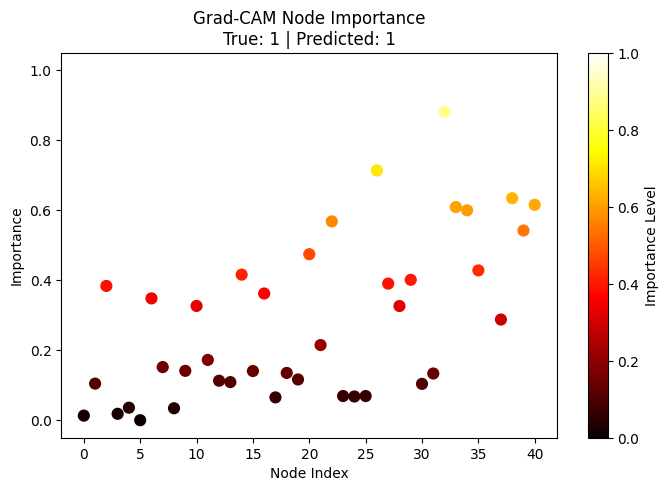

In [58]:
# ==========================================
#  GRAD-CAM STYLE VISUALIZATION 
# ==========================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import degree

# ---------------------------------------------------
# 1. Pick a sample test graph to visualize
# ---------------------------------------------------
image_index =200  # change index to view other samples
sample_graph = test_graphs[image_index].to(device)

# ---------------------------------------------------
# 2. Set model to evaluation mode
# ---------------------------------------------------
for layer in [conv1, conv2, conv3, bn1, bn2, bn3, fc1, fc2]:
    layer.eval()

# ---------------------------------------------------
# 3. Prepare node features with gradient tracking
# ---------------------------------------------------
sample_graph.x = sample_graph.x.clone().detach().to(device)
sample_graph.x.requires_grad = True

# Optional: add degree feature if used
use_degree_feature = False
x = sample_graph.x
if use_degree_feature:
    deg = degree(sample_graph.edge_index[0], num_nodes=sample_graph.x.size(0)).unsqueeze(1)
    x = torch.cat([x, deg.to(device)], dim=1)

# ---------------------------------------------------
# 4.  Forward pass through GATv2
# ---------------------------------------------------
# Layer 1
x1 = conv1(x, sample_graph.edge_index)
x1 = bn1(x1)
x1 = F.elu(x1)
x1 = F.dropout(x1, p=0.25, training=False)

# Layer 2
x2 = conv2(x1, sample_graph.edge_index)
x2 = bn2(x2)
x2 = F.elu(x2 + 0.2 * x1)
x2 = F.dropout(x2, p=0.25, training=False)

# Layer 3
x3 = conv3(x2, sample_graph.edge_index)
x3 = bn3(x3)
if x2.shape[1] != x3.shape[1]:
    proj_res3 = torch.nn.Linear(x2.shape[1], x3.shape[1]).to(device)
    x2 = proj_res3(x2)
x3 = F.elu(x3 + 0.3 * x2)

# Pooling (global mean + max)
pooled = torch.cat([
    global_mean_pool(x3, sample_graph.batch),
    global_max_pool(x3, sample_graph.batch)
], dim=1)

# Dynamically adjust fc1 input size if needed
if fc1.in_features != pooled.size(1):
    fc1 = torch.nn.Linear(pooled.size(1), fc1.out_features).to(device)

# Fully connected layers
x_fc = F.relu(fc1(pooled))
out = fc2(x_fc)

# ---------------------------------------------------
# 5.  Grad-CAM computation
# ---------------------------------------------------
true_label = sample_graph.y.item()      # ground-truth
pred_class = out.argmax(dim=1).item()   # predicted class

print("True class:", true_label)
print("Predicted class:", pred_class)

# Backprop for the predicted class
target = out[0, pred_class]
target.backward()  # safe backward on fresh forward pass

# Node-wise importance
grads = sample_graph.x.grad.abs().sum(dim=1).detach().cpu().numpy()
importance = (grads - grads.min()) / (grads.max() - grads.min() + 1e-8)

# ---------------------------------------------------
# 6.  Visualization
# ---------------------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(range(len(importance)), importance, c=importance, cmap="hot", s=60)
plt.title(f"Grad-CAM Node Importance\nTrue: {true_label} | Predicted: {pred_class}")
plt.xlabel("Node Index")
plt.ylabel("Importance")
plt.colorbar(label="Importance Level")
plt.show()


In [59]:
print("Predicted class name:", label_encoder.classes_[pred_class])
print("True class name:", label_encoder.classes_[true_label])

Predicted class name: meningioma_tumor
True class name: meningioma_tumor


Predicted class: meningioma_tumor
True class: meningioma_tumor


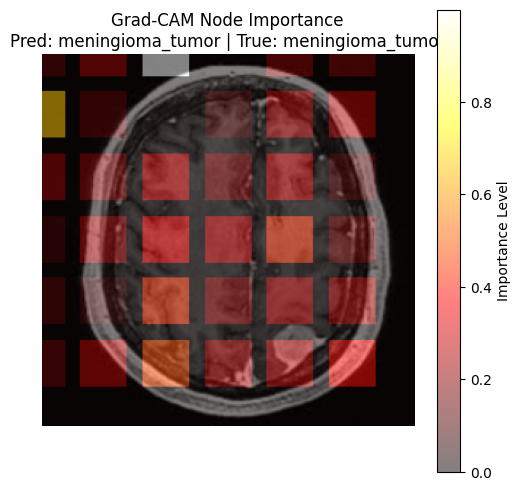

In [60]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import degree

# -----------------------------
# CONFIGURATION
# -----------------------------
image_index = 200   # Pick any test graph
patch_size = 32

# Rebuild test image paths (automatically)
test_image_paths = [
    os.path.join(test_dir, c, f)
    for c in classes
    for f in os.listdir(os.path.join(test_dir, c))
    if f.lower().endswith(('.jpg', '.png'))
]

# -----------------------------
# SELECT GRAPH
# -----------------------------
data = test_graphs[image_index].to(device)

# -----------------------------
# SET MODEL TO EVAL
# -----------------------------
for layer in [conv1, conv2, conv3, bn1, bn2, bn3, fc1, fc2, proj_res3]:
    layer.eval()

data.x = data.x.clone().detach().to(device)
data.x.requires_grad = True

# -----------------------------
# FORWARD PASS
# -----------------------------
x = data.x

# Optional: add degree feature
use_degree_feature = False
if use_degree_feature:
    deg = degree(data.edge_index[0], num_nodes=data.x.size(0)).unsqueeze(1)
    x = torch.cat([x, deg.to(device)], dim=1)

# Layer 1
x1 = conv1(x, data.edge_index)
x1 = bn1(x1)
x1 = F.elu(x1)

# Layer 2
x2 = conv2(x1, data.edge_index)
x2 = bn2(x2)
x2 = F.elu(x2 + 0.2 * x1)

# Layer 3
x3 = conv3(x2, data.edge_index)
x3 = bn3(x3)
# Project residual if necessary
if x2.shape[1] != x3.shape[1]:
    proj_res3 = torch.nn.Linear(x2.shape[1], x3.shape[1]).to(device)
    x2 = proj_res3(x2)
x3 = F.elu(x3 + 0.3 * x2)

# Pooling
pooled = torch.cat([
    global_mean_pool(x3, data.batch),
    global_max_pool(x3, data.batch)
], dim=1)

# Fully connected layers
x_fc = F.relu(fc1(pooled))
out = fc2(x_fc)

pred_class = out.argmax(dim=1).item()
true_class = data.y.item()
print(f"Predicted class: {label_encoder.classes_[pred_class]}")
print(f"True class: {label_encoder.classes_[true_class]}")

# -----------------------------
# BACKWARD PASS (Grad-CAM)
# -----------------------------
target = out[0, pred_class]
target.backward()

# Node importance
grads = data.x.grad.abs().sum(dim=1).cpu().numpy()
importance = (grads - grads.min()) / (grads.max() - grads.min() + 1e-8)

# -----------------------------
# LOAD ORIGINAL IMAGE
# -----------------------------
img_path = test_image_paths[image_index]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
H, W = img.shape[:2]

# -----------------------------
# BUILD HEATMAP
# -----------------------------
heatmap = np.zeros((H, W))

# Use saved patch coordinates if available
if hasattr(data, 'coords'):
    coords = data.coords.cpu().numpy()
else:
    # fallback: evenly spaced grid
    side = int(np.sqrt(len(importance)))
    coords = np.array([(i/side, j/side) for i in range(side) for j in range(side)])

for idx, (cy_norm, cx_norm) in enumerate(coords):
    cy, cx = int(cy_norm * H), int(cx_norm * W)
    y1, y2 = max(0, cy - patch_size//2), min(H, cy + patch_size//2)
    x1, x2 = max(0, cx - patch_size//2), min(W, cx + patch_size//2)
    if idx < len(importance):
        heatmap[y1:y2, x1:x2] = importance[idx]

heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

# -----------------------------
# VISUALIZE OVER ORIGINAL IMAGE
# -----------------------------
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap='hot', alpha=0.5)
plt.title(f"Grad-CAM Node Importance\nPred: {label_encoder.classes_[pred_class]} | True: {label_encoder.classes_[true_class]}")
plt.axis('off')
plt.colorbar(label="Importance Level")
plt.show()


Device: cpu


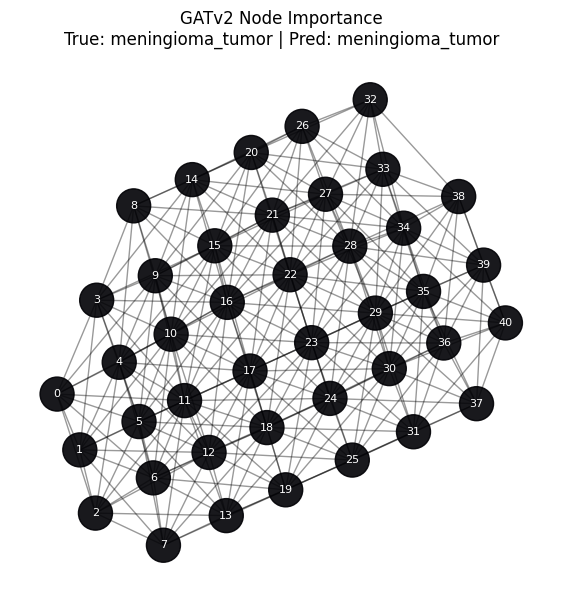

<Figure size 800x800 with 0 Axes>

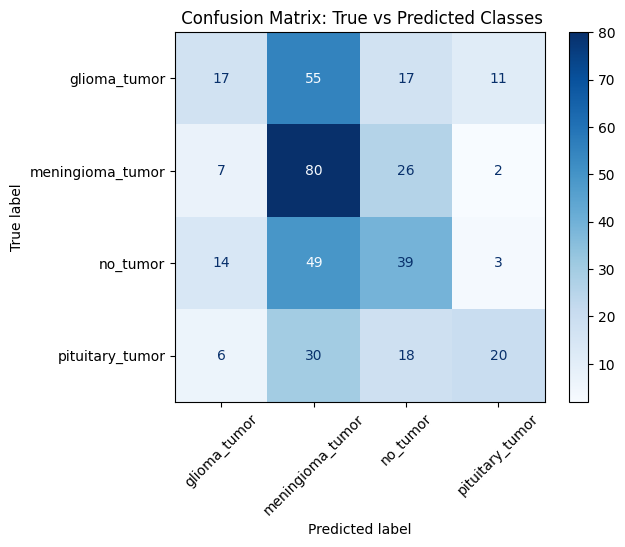


 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.39      0.17      0.24       100
meningioma_tumor       0.37      0.70      0.49       115
        no_tumor       0.39      0.37      0.38       105
 pituitary_tumor       0.56      0.27      0.36        74

        accuracy                           0.40       394
       macro avg       0.43      0.38      0.37       394
    weighted avg       0.42      0.40      0.37       394

 Overall Accuracy: 0.3959


In [61]:
# ============================================
# EXPLAINABILITY + EVALUATION METRICS
# ============================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.utils import to_networkx
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# Model architecture (must match training)
# ----------------------------
hidden_channels = 96  # same as during training

conv1 = GATv2Conv(3, hidden_channels, heads=4, concat=False).to(device)
bn1 = torch.nn.BatchNorm1d(hidden_channels).to(device)

conv2 = GATv2Conv(hidden_channels, hidden_channels, heads=4, concat=False).to(device)
bn2 = torch.nn.BatchNorm1d(hidden_channels).to(device)

conv3 = GATv2Conv(hidden_channels, hidden_channels // 2, heads=4, concat=False).to(device)
bn3 = torch.nn.BatchNorm1d(hidden_channels // 2).to(device)

proj_res3 = torch.nn.Linear(hidden_channels, hidden_channels // 2).to(device)

fc1 = torch.nn.Linear(hidden_channels // 2, 128).to(device)
fc2 = torch.nn.Linear(128, 4).to(device)  # num_classes = 4

# ----------------------------
# Load checkpoint
# ----------------------------
checkpoint = torch.load("best_gatv2_model_fixed.pth", map_location=device)
conv1.load_state_dict(checkpoint["conv1"])
conv2.load_state_dict(checkpoint["conv2"])
conv3.load_state_dict(checkpoint["conv3"])
bn1.load_state_dict(checkpoint["bn1"])
bn2.load_state_dict(checkpoint["bn2"])
bn3.load_state_dict(checkpoint["bn3"])
proj_res3.load_state_dict(checkpoint["proj_res3"])
fc1.load_state_dict(checkpoint["fc1"])
fc2.load_state_dict(checkpoint["fc2"])

for layer in [conv1, conv2, conv3, bn1, bn2, bn3, proj_res3, fc1, fc2]:
    layer.eval()

# ----------------------------
# Safe attention handling
# ----------------------------
def safe_mean(att):
    if att is None:
        return torch.zeros(1, device=device)
    return att.mean(dim=1) if att.dim() == 2 else att.view(-1)

def accumulate_node_importance(edge_index, att, num_nodes):
    att = safe_mean(att)
    edge_src = edge_index[0].cpu().numpy()
    importance = np.zeros(num_nodes)
    for i, src in enumerate(edge_src):
        if src < num_nodes and i < len(att):
            importance[src] += att[i].item()
    return importance

# ----------------------------
# Evaluation
# ----------------------------
all_true, all_pred = [], []

with torch.no_grad():
    for graph in test_graphs:
        graph = graph.to(device)

        # Dummy batch for single-graph pooling
        if not hasattr(graph, "batch"):
            batch = torch.zeros(graph.num_nodes, dtype=torch.long, device=device)
        else:
            batch = graph.batch

        # Forward pass
        x = F.elu(bn1(conv1(graph.x, graph.edge_index)))
        att1 = getattr(conv1, "_alpha", None)

        x_res = x
        x = F.elu(bn2(conv2(x, graph.edge_index)) + 0.3 * x_res)
        att2 = getattr(conv2, "_alpha", None)

        x_res = proj_res3(x)
        x = F.elu(bn3(conv3(x, graph.edge_index)) + 0.3 * x_res)
        att3 = getattr(conv3, "_alpha", None)

        x_pool = global_mean_pool(x, batch)
        out = fc2(F.relu(fc1(x_pool)))

        pred = out.argmax(dim=1).cpu().item()
        true = graph.y.cpu().item()

        all_pred.append(pred)
        all_true.append(true)

        # Explainability for one graph only
        if graph == test_graphs[200]:
            num_nodes = graph.num_nodes
            imp1 = accumulate_node_importance(graph.edge_index, att1, num_nodes)
            imp2 = accumulate_node_importance(graph.edge_index, att2, num_nodes)
            imp3 = accumulate_node_importance(graph.edge_index, att3, num_nodes)

            node_importance = imp1 + imp2 + imp3
            node_importance = (node_importance - node_importance.min()) / (
                node_importance.max() - node_importance.min() + 1e-8
            )

            G = to_networkx(graph, to_undirected=True)
            pos = nx.spring_layout(G, seed=42)

            plt.figure(figsize=(7, 7))
            nx.draw_networkx_nodes(
                G, pos,
                node_color=node_importance,
                cmap='inferno',
                node_size=600,
                alpha=0.9
            )
            nx.draw_networkx_edges(G, pos, alpha=0.4)
            nx.draw_networkx_labels(G, pos, font_size=8, font_color='white')
            plt.title(f"GATv2 Node Importance\nTrue: {label_encoder.classes_[true]} | Pred: {label_encoder.classes_[pred]}")
            plt.axis("off")
            plt.show()

# ----------------------------
# Confusion Matrix + Metrics
# ----------------------------
cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(" Confusion Matrix: True vs Predicted Classes")
plt.show()

print("\n Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_encoder.classes_))
print(f" Overall Accuracy: {accuracy_score(all_true, all_pred):.4f}")
